# Activeloop深度内存

**我们如何在文档问答中获得+15%的RAG点击率改进？**


最近，检索增强生成器（RAGs）引起了广泛关注。随着先进的RAG技术和代理的出现，它们扩展了RAGs的潜力。然而，一些挑战可能限制了将RAGs整合到生产中。在实施RAGs到生产环境时，需要考虑的主要因素是准确性（召回率）、成本和延迟。对于基本用例，OpenAI的Ada模型配合简单的相似性搜索可以产生令人满意的结果。然而，对于搜索过程中更高的准确性或召回率，可能需要采用先进的检索技术。这些方法可能涉及不同的数据块大小、多次重写查询等，可能会增加延迟和成本。Activeloop的Deep Memory是Activeloop Deep Lake用户可以使用的功能，它通过引入一个微小的神经网络层，训练以将用户查询与语料库中相关数据匹配，解决了这些问题。虽然这种添加在搜索过程中带来了最小的延迟，但它可以将检索准确性提高高达27%，并且成本效益高，使用简单，无需额外的高级RAG技术。[Activeloop的Deep Memory](https://www.activeloop.ai/resources/use-deep-memory-to-boost-rag-apps-accuracy-by-up-to-22/)


In [ ]:
%pip install llama-index-vector-stores-deeplake
%pip install llama-index-llms-openai

In [ ]:
import nest_asyncio
import os
import getpass

nest_asyncio.apply()

In [ ]:
!pip install deeplake beautifulsoup4 html2text tiktoken openai llama-index python-dotenv

对于本教程，我们将解析deeplake文档，并创建一个能够回答文档中问题的RAG系统。

教程可以分为几个部分：
1. [数据集创建和上传](#1-dataset-creation-and-ingestion)
2. [生成合成查询并训练deep_memory](#2-training-deep-memory)
3. [评估deep memory性能](#3-deepmemory-evaluation)
4. [Deep Memory推理](#4-deep-memory-inference)


<a name="training"></a>
## 1. 数据集创建和导入


让我使用BeautifulSoup解析所有链接，并将它们转换为LlamaIndex文档：


In [ ]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

def get_all_links(url):
    response = requests.get(url)
    if response.status_code != 200:
        print(f"无法获取页面：{url}")
        return []

    soup = BeautifulSoup(response.content, "html.parser")

    # 查找所有包含链接的'a'标签，通常包含href属性
    links = [
        urljoin(url, a["href"])
        for a in soup.find_all("a", href=True)
        if a["href"]
    ]

    return links

In [ ]:
from langchain.document_loaders import AsyncHtmlLoader
from langchain.document_transformers import Html2TextTransformer
from llama_index.core import Document


def load_documents(url):
    all_links = get_all_links(url)
    loader = AsyncHtmlLoader(all_links)
    docs = loader.load()

    html2text = Html2TextTransformer()
    docs_transformed = html2text.transform_documents(docs)
    docs = [Document.from_langchain_format(doc) for doc in docs_transformed]
    return docs


docs = load_documents("https://docs.deeplake.ai/en/latest/")

Fetching pages: 100%|##########| 120/120 [00:13<00:00,  8.70it/s]


In [ ]:
len(docs)

120

In [ ]:
from llama_index.core.evaluation import generate_question_context_pairs
from llama_index.core import (
    VectorStoreIndex,
    SimpleDirectoryReader,
    StorageContext,
)
from llama_index.vector_stores.deeplake import DeepLakeVectorStore
from llama_index.core.node_parser import SimpleNodeParser
from llama_index.llms.openai import OpenAI

os.environ["OPENAI_API_KEY"] = getpass.getpass("输入您的OpenAI API密钥：")
# # 如果您没有使用CLI登录，则需要activeloop令牌：`activeloop login -u <USERNAME> -p <PASSWORD>`
os.environ["ACTIVELOOP_TOKEN"] = getpass.getpass(
    "输入您的ActiveLoop API令牌："
)  # 从https://app.activeloop.ai获取您的API令牌，在右上角的个人资料图片中，选择“API Tokens”
token = os.getenv("ACTIVELOOP_TOKEN")

vector_store = DeepLakeVectorStore(
    dataset_path="hub://activeloop-test/deeplake_docs_deepmemory2",
    overwrite=False,  # 设置为True以覆盖现有数据集
    runtime={"tensor_db": True},
    token=token,
)

Deep Lake Dataset in hub://activeloop-test/deeplake_docs_deepmemory2 already exists, loading from the storage


In [ ]:
def create_modules(vector_store, docs=[], populate_vector_store=True):
    if populate_vector_store:
        node_parser = SimpleNodeParser.from_defaults(chunk_size=512)
        nodes = node_parser.get_nodes_from_documents(docs)
    else:
        nodes = []

    # 默认情况下，节点的id设置为随机uuid。为了确保每次运行相同的id，我们手动设置它们。
    for idx, node in enumerate(nodes):
        node.id_ = f"node_{idx}"

    llm = OpenAI(model="gpt-4")
    storage_context = StorageContext.from_defaults(vector_store=vector_store)
    return storage_context, nodes, llm

In [ ]:
(
    storage_context,
    nodes,
    llm,
) = create_modules(
    docs=docs,
    vector_store=vector_store,
    # populate_vector_store=False, # 取消注释此行以跳过填充向量存储
)

In [ ]:
vector_index = VectorStoreIndex(nodes, storage_context=storage_context)
deep_memory_retriever = vector_index.as_retriever(
    similarity_top_k=4, deep_memory=True
)

<a name="training"></a>
## 2. 训练深度记忆网络


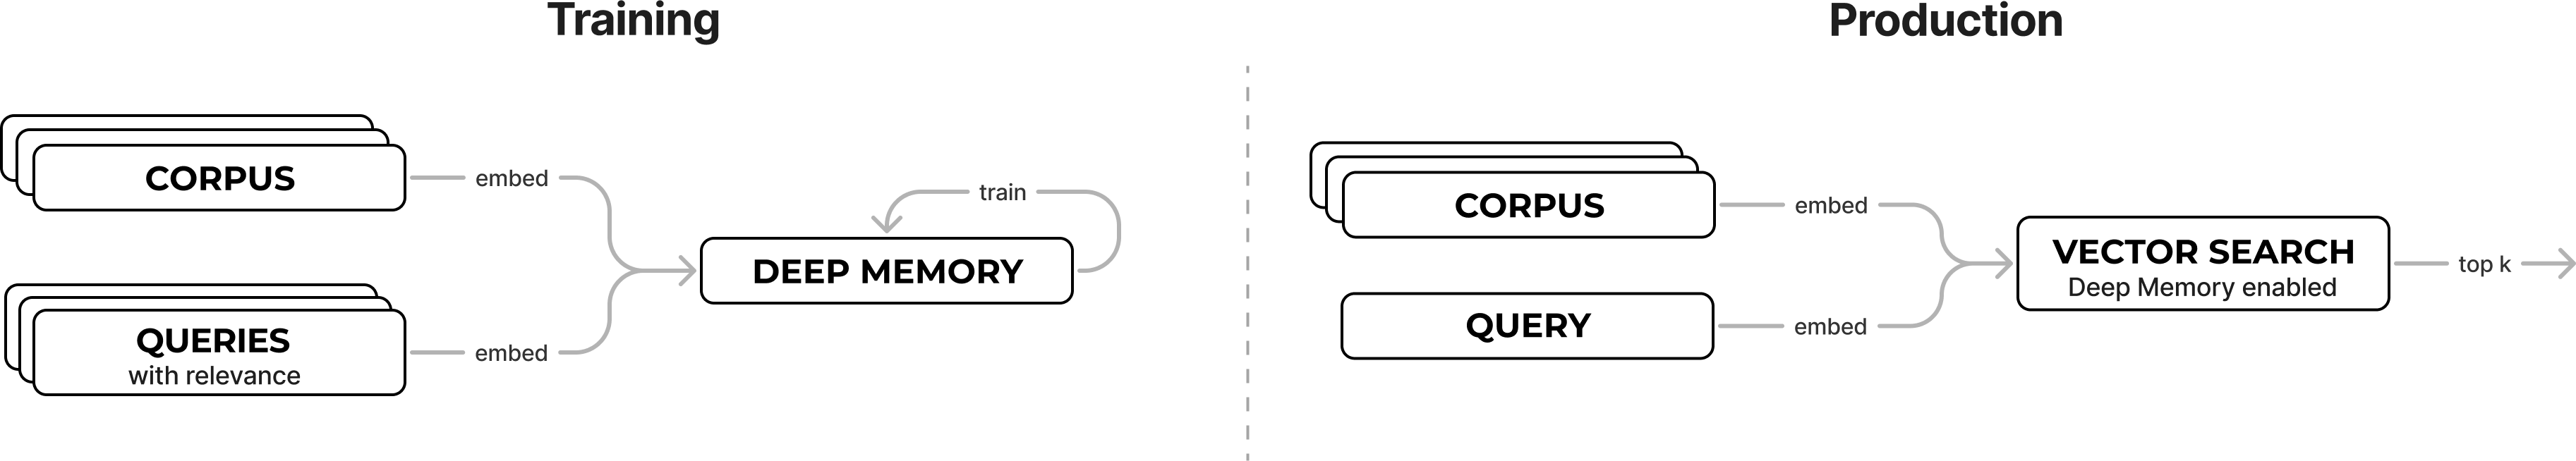


在上面，我们展示了deep_memory工作的整体架构。因此，您可以看到，为了训练它，您需要相关性、查询以及语料库数据（我们想要查询的数据）。语料库数据已经在上一节中填充；在这里，我们将生成问题和相关性。

1. `questions` - 是一组文本字符串，其中每个字符串代表一个查询。
2. `relevance` - 包含每个问题的地面真相链接。可能有几个文档包含对给定问题的答案。因此，相关性是一个List[List[tuple[str, float]]]，其中外部列表表示查询，内部列表表示相关文档。元组包含一个str、float对，其中字符串表示源文档的id（对应数据集中的id张量），而浮点数表示当前文档与问题的相关程度。


In [ ]:
from llama_index.core.evaluation import (
    generate_question_context_pairs,
    EmbeddingQAFinetuneDataset,
)
import random


def create_train_test_datasets(
    number_of_samples=600, llm=None, nodes=None, save=False
):
    random_indices = random.sample(range(len(nodes)), number_of_samples)

    ratio = int(len(random_indices) * 0.8)

    train_indices = random_indices[:ratio]
    test_indices = random_indices[ratio:]

    train_nodes = [nodes[i] for i in train_indices]
    test_nodes = [nodes[i] for i in test_indices]

    train_qa_dataset = generate_question_context_pairs(
        train_nodes, llm=llm, num_questions_per_chunk=1
    )

    test_qa_dataset = generate_question_context_pairs(
        test_nodes, llm=llm, num_questions_per_chunk=1
    )

    # [optional] save
    if save:
        train_qa_dataset.save_json(
            f"deeplake_docs_{number_of_samples}_train.json"
        )
        test_qa_dataset.save_json(
            f"deeplake_docs_{number_of_samples}_test.json"
        )
    return train_qa_dataset, test_qa_dataset

In [ ]:
train_qa_dataset, test_qa_dataset = create_train_test_datasets(
    number_of_samples=600, llm=llm, nodes=nodes, save=True
)

  4%|▍         | 19/480 [02:25<1:04:00,  8.33s/it]

In [ ]:
train_qa_dataset = EmbeddingQAFinetuneDataset.from_json(
    "deeplake_docs_600_train.json"
)
test_qa_dataset = EmbeddingQAFinetuneDataset.from_json(
    "deeplake_docs_600_test.json"
)

In [ ]:
def create_query_relevance(qa_dataset):
    """将llama-index数据集转换为深度记忆训练的正确格式的函数"""
    queries = [text for _, text in qa_dataset.queries.items()]
    relevant_docs = qa_dataset.relevant_docs
    relevance = []
    for doc in relevant_docs:
        relevance.append([(relevant_docs[doc][0], 1)])
    return queries, relevance

In [ ]:
train_queries, train_relevance = create_query_relevance(train_qa_dataset)
test_queries, test_relevance = create_query_relevance(test_qa_dataset)

In [ ]:
train_queries[:3]

['In the context of creating a bounding box tensor in a dataset, explain the significance of the "coords" argument and its keys "type" and "mode". What does the "type" key specify about the bounding box coordinates?',
 'Explain the process of creating an intrinsics tensor and appending intrinsics matrices in the context of computer vision. What are the dimensions of the intrinsics parameters and what do they represent? Also, describe the concept of a Segmentation Mask Htype and its role in image processing.',
 'In the context of querying for images in the MNIST Train Dataset using `ds.query`, what does the command "select * where labels == 0" signify and what is the expected output?']

In [ ]:
train_relevance[:3]

[[('node_788', 1)], [('node_861', 1)], [('node_82', 1)]]

In [ ]:
test_queries[:3]

['What are the steps to update the information of keypoints and connections in a tensor, and what types of data can be appended to keypoints?',
 'What is the command to create a mesh tensor in DeepLake and what are the supported compressions? Also, explain how to append a ply file containing mesh data to this tensor.',
 'What is a Sequence htype in the context of tensors and how does it function as a wrapper for other htypes? Provide examples.']

In [ ]:
test_relevance[:3]

[[('node_933', 1)], [('node_671', 1)], [('node_471', 1)]]

In [ ]:
from langchain.embeddings.openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()


job_id = vector_store.vectorstore.deep_memory.train(
    queries=train_queries,
    relevance=train_relevance,
    embedding_function=embeddings.embed_documents,
)

Starting DeepMemory training job
Your Deep Lake dataset has been successfully created!


Preparing training data for deepmemory:


Creating 483 embeddings in 1 batches of size 483:: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it]


DeepMemory training job started. Job ID: 65421a5003888c9ca36c72e8


In [ ]:
vector_store.vectorstore.deep_memory.status(job_id)

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/adilkhan/deeplake_docs_deepmemory2
--------------------------------------------------------------
|                  65421a5003888c9ca36c72e8                  |
--------------------------------------------------------------
| status                     | completed                     |
--------------------------------------------------------------
| progress                   | eta: 12.2 seconds             |
|                            | recall@10: 67.01% (+18.56%)   |
--------------------------------------------------------------
| results                    | recall@10: 67.01% (+18.56%)   |
--------------------------------------------------------------




<a name="training"></a>
## 3. DeepMemory 模型评估


太棒了！训练取得了一些显著的改进！现在，让我们评估它在测试集上的性能。


In [ ]:
recalls = vector_store.vectorstore.deep_memory.evaluate(
    queries=test_queries,
    relevance=test_relevance,
    embedding_function=embeddings.embed_documents,
)

info Wed Nov  1 09:32:44 2023 GMT         Added distance metric `deepmemory_distance`.
Embedding queries took 0.95 seconds
---- Evaluating without Deep Memory ---- 
Recall@1:	  12.5%
Recall@3:	  23.3%
Recall@5:	  30.8%
Recall@10:	  50.8%
Recall@50:	  94.2%
Recall@100:	  95.8%
---- Evaluating with Deep Memory ---- 
Recall@1:	  11.7%
Recall@3:	  27.5%
Recall@5:	  40.8%
Recall@10:	  65.0%
Recall@50:	  96.7%
Recall@100:	  98.3%


令人印象深刻！我们观察到测试集上召回率增加了15%。接下来，让我们使用RetrieverEvaluator来检查MRR（平均倒数排名）和命中率。


In [ ]:
import pandas as pd


def display_results(eval_results):
    """显示evaluate的结果。"""
    hit_rates = []
    mrrs = []
    names = []
    for name, eval_result in eval_results.items():
        metric_dicts = []
        for er in eval_result:
            metric_dict = er.metric_vals_dict
            metric_dicts.append(metric_dict)

        full_df = pd.DataFrame(metric_dicts)

        hit_rate = full_df["hit_rate"].mean()
        mrr = full_df["mrr"].mean()

        hit_rates.append(hit_rate)
        mrrs.append(mrr)
        names.append(name)

    metric_df = pd.DataFrame(
        [
            {"retrievers": names[i], "hit_rate": hit_rates[i], "mrr": mrrs[i]}
            for i in range(2)
        ],
    )

    return metric_df

评估使用深度记忆进行检索的性能：


In [ ]:
from llama_index.core.evaluation import RetrieverEvaluator

deep_memory_retriever = vector_index.as_retriever(
    similarity_top_k=10, vector_store_kwargs={"deep_memory": True}
)
dm_retriever_evaluator = RetrieverEvaluator.from_metric_names(
    ["mrr", "hit_rate"], retriever=deep_memory_retriever
)

dm_eval_results = await dm_retriever_evaluator.aevaluate_dataset(
    test_qa_dataset, retriever=dm_retriever_evaluator
)

In [ ]:
from llama_index.core.evaluation import RetrieverEvaluator

naive_retriever = vector_index.as_retriever(similarity_top_k=10)
naive_retriever_evaluator = RetrieverEvaluator.from_metric_names(
    ["mrr", "hit_rate"], retriever=naive_retriever
)

naive_eval_results = await naive_retriever_evaluator.aevaluate_dataset(
    test_qa_dataset, retriever=naive_retriever
)

In [ ]:
eval_results = {
    f"{mode} with Deep Memory top-10 eval": eval_result
    for mode, eval_result in zip(
        ["with", "without"], [dm_eval_results, naive_eval_results]
    )
}

display_results(eval_results)

retrievers  hit_rate       mrr
0     with with Deep Memory top-10 eval  0.650000  0.244775
1  without with Deep Memory top-10 eval  0.508333  0.215129

不仅命中率增加了，而且MRR也增加了。


<a name="training"></a>
## 4. 深度记忆推断


In [ ]:
query_engine = vector_index.as_query_engine(
    vector_store_kwargs={"deep_memory": True}, llm=llm
)
response = query_engine.query(
    "How can you connect your own storage to the deeplake?"
)
print(response)

info Wed Nov  1 11:37:33 2023 GMT         Can't find any metric in the dataset.
You can connect your own storage to deeplake by using the `connect()` function in the deeplake API.


In [ ]:
query_engine = vector_index.as_query_engine(
    vector_store_kwargs={"deep_memory": False}, llm=llm
)
response = query_engine.query(
    "How can you connect your own storage to the deeplake?"
)
print(response)

The context does not provide information on how to connect your own storage to Deep Lake.


根据我们的观察，没有“深度记忆”的情况下，我们的模型往往会产生不准确的结果，因为它检索到了错误的上下文。
